In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import math

In [2]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 3)  # Prob of Left

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [5]:
def transformState(S_t):
    return [ math.atan2( S_t[0], S_t[1]), math.atan2( S_t[2], S_t[3]), S_t[4], S_t[5] ]

episode_durations = []
episode_rewards = []
episode_success = []

def main():

    # Parameters
    num_episode = 1000
    batch_size = 5
    learning_rate = 0.01
    gamma = 0.99

    env = gym.make('Acrobot-v1')
    policy_net = PolicyNet()
    policy_optimizer = torch.optim.SGD(policy_net.parameters(), lr=learning_rate)

    # Batch History
    state_pool = []
    action_pool = []
    reward_pool = []
    steps = 0


    for e in range(num_episode):

        state = env.reset()[0]
        state = np.array(transformState(state))
        state = torch.from_numpy(state).float()
        state = Variable(state)

        for t in range(1000):

            probs = policy_net(state)
            m = Categorical(probs)
            action = m.sample()

            action = action.data.numpy().astype(int)
            stepData = env.step(action)
            next_state, reward, done, truncated, info = stepData[0], stepData[1], stepData[2], stepData[3], stepData[4]
            next_state = np.array(transformState(next_state))

            # To mark boundarys between episodes
            if done:
                reward = 0

            state_pool.append(state)
            action_pool.append(float(action))
            reward_pool.append(reward)

            state = next_state
            state = torch.from_numpy(state).float()
            state = Variable(state)

            steps += 1

            if done:
                episode_durations.append(t + 1)
                print("Episode:",e,"\tDuration:",t+1)
                episode_rewards.append(-t)

                break

        # Update policy
        if e > 0 and e % batch_size == 0:

            # Discount reward
            return_G = 0
            for i in reversed(range(steps)):
                if reward_pool[i] == 0:
                    return_G = 0
                else:
                    return_G = return_G * gamma + reward_pool[i]
                    reward_pool[i] = return_G

            # print(reward_pool)
            # print(len(reward_pool))

            # Normalize reward
            # reward_mean = np.mean(reward_pool)
            # reward_std = np.std(reward_pool)
            # for i in range(steps):
            #     reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

            # Gradient Desent
            policy_optimizer.zero_grad()

            for i in range(steps):
                state = state_pool[i]
                action = Variable(torch.FloatTensor([action_pool[i]]))
                reward = reward_pool[i]

                probs = policy_net(state)
                m = Categorical(probs)
                loss = -m.log_prob(action) * reward  # Negtive score function x reward
                loss.backward()

            policy_optimizer.step()
            
            
            state_pool = []
            action_pool = []
            reward_pool = []
            steps = 0


if __name__ == '__main__':
    main()

Episode: 3 	Duration: 992
Episode: 9 	Duration: 630
Episode: 17 	Duration: 726


/home/devraj/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Episode: 26 	Duration: 413
Episode: 28 	Duration: 659
Episode: 38 	Duration: 781
Episode: 41 	Duration: 649
Episode: 45 	Duration: 781
Episode: 51 	Duration: 637
Episode: 58 	Duration: 652
Episode: 71 	Duration: 431
Episode: 74 	Duration: 786
Episode: 83 	Duration: 699
Episode: 90 	Duration: 810
Episode: 95 	Duration: 552
Episode: 97 	Duration: 772
Episode: 106 	Duration: 938
Episode: 107 	Duration: 965
Episode: 109 	Duration: 873
Episode: 110 	Duration: 524
Episode: 111 	Duration: 317
Episode: 112 	Duration: 877
Episode: 113 	Duration: 957
Episode: 123 	Duration: 997
Episode: 129 	Duration: 839
Episode: 132 	Duration: 951
Episode: 138 	Duration: 612
Episode: 139 	Duration: 620
Episode: 145 	Duration: 803
Episode: 146 	Duration: 839
Episode: 150 	Duration: 708
Episode: 152 	Duration: 591
Episode: 155 	Duration: 800
Episode: 159 	Duration: 581
Episode: 162 	Duration: 976
Episode: 164 	Duration: 894
Episode: 168 	Duration: 534
Episode: 169 	Duration: 410
Episode: 170 	Duration: 815
Episo

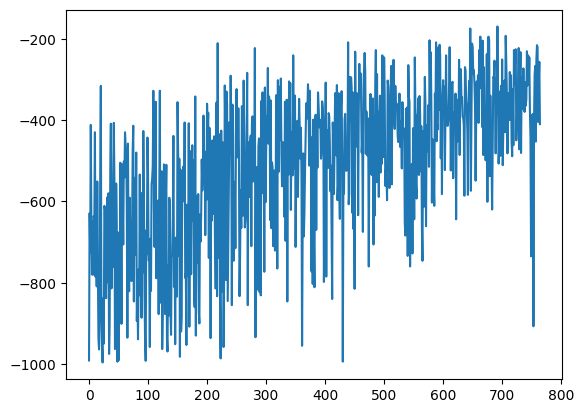

In [6]:
plt.figure()
plt.plot(episode_rewards)
plt.show()